In [2]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import math
from itertools import product
import datetime as dt

In [3]:
from platform import python_version

print(python_version())

3.8.5


In [4]:
#maxTweets = 100000

#keyword = 'Pfizer'

#Open/create a file to append data to
#csvFile = open('pfe_tweets_result.csv', 'a', newline='', encoding='utf8')

#Use csv writer
#csvWriter = csv.writer(csvFile)
#csvWriter.writerow(['id','date','tweet',]) 


#for i,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword + ' lang:en since:2020-01-01 until:2020-10-30 -filter:links -filter:replies').get_items()):
#        if i > maxTweets :
#            break  
#        csvWriter.writerow([tweet.id, tweet.date, tweet.content])
#csvFile.close()

In [5]:
analyzer = SentimentIntensityAnalyzer()

In [6]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    # return(score['compound']) #prints only compound score
    return("{:-<40} {}".format(sentence, str(score)))


print(sentiment_analyzer_scores("PFE sucks!"))

PFE sucks!------------------------------ {'neg': 0.736, 'neu': 0.264, 'pos': 0.0, 'compound': -0.4199}


In [7]:
df = pd.read_csv('/Users/Graham/data-works/twitter-sentiment-analysis/pfe_tweets_result.csv')
df = df.set_index('date')

In [8]:
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['tweet']] 
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['tweet']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['tweet']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['tweet']]
# df['c_SMA'] = df['compound'].rolling(100).mean()

In [9]:
df.tail()

,id,tweet,compound,neg,neu,pos
date,,,,,,
2020-01-01 07:30:54+00:00,1212274986116882432,"#healthcare Get ready for it ,,,,Trump never a...",0.5093,0.000,0.896,0.104
2020-01-01 06:28:03+00:00,1212259169325051905,Exclusive: Drugmakers from Pfizer to GSK to hi...,0.5106,0.000,0.913,0.087
2020-01-01 06:21:47+00:00,1212257594275876867,Drugmakers from Pfizer to GSK to hike prices o...,-0.6751,0.179,0.760,0.060
2020-01-01 01:51:56+00:00,1212189683272294401,(12/31/2019) Per Reuters pharmaceutical compan...,0.0000,0.000,1.000,0.000
2020-01-01 00:34:37+00:00,1212170226940497920,Drugmakers from Pfizer to GSK to hike prices o...,0.3612,0.000,0.865,0.135


In [10]:
print(np.average(df['compound']))
print(np.average(df['neg']))
print(np.average(df['neu']))
print(np.average(df['pos']))

0.18320687029359506
0.04815077417717235
0.8512512902952872
0.10059666638463491


In [11]:
#plt.figure(figsize=(20,20))
#plt.xlabel('Date')
#plt.ylabel('Compound Simple MA')
#plt.plot(df['c_SMA'])

In [12]:
df.index = pd.to_datetime(df.index, errors='coerce',format='%Y-%m-%d %H:%M:%S')

In [13]:
df = df.resample('D').mean()

In [14]:
# Make data index timezone naive
df.tz_localize(None)

,id,compound,neg,neu,pos
date,,,,,
2020-01-01,1.212331e+18,0.100409,0.055455,0.867091,0.077455
2020-01-02,1.212687e+18,0.120691,0.032000,0.897909,0.070091
2020-01-03,1.213059e+18,0.128910,0.044900,0.870200,0.084800
2020-01-04,1.213495e+18,-0.163814,0.120143,0.743429,0.136571
2020-01-05,1.213822e+18,0.063533,0.060333,0.772222,0.167444
...,...,...,...,...,...
2020-11-08,NaN,NaN,NaN,NaN,NaN
2020-11-09,NaN,NaN,NaN,NaN,NaN
2020-11-10,NaN,NaN,NaN,NaN,NaN


In [15]:
# Removing Weekends from daily tweet sentiment dataframe
df = df.loc[df.index.to_series().dt.weekday < 5]

In [16]:
# No weekends sentiment data to CSV file
df.to_csv('tweets_resampled_mean_no_weekends.csv')

In [17]:
# Combining the PFE ticker frame and the tweet sentiment resampled frame

# ** had to manually alter the date column title to --> 'Date' and remove hour/s/m data 
corrected_df = pd.read_csv("/Users/Graham/data-works/twitter-sentiment-analysis/tweets_no_wks_corrected.csv", parse_dates=True, index_col=0)
_pfe = pd.read_csv("/Users/Graham/data-works/twitter-sentiment-analysis/PFE.csv", parse_dates=True, index_col=0)
combined_df = corrected_df.merge(_pfe, on='Date',how='outer').dropna()


In [18]:
combined_df.head()

,compound,neg,neu,pos,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,
2020-01-02,0.120691,0.032000,0.897909,0.070091,39.299999,39.349998,38.880001,39.139999,37.603886,15668000.0
2020-01-03,0.128910,0.044900,0.870200,0.084800,38.720001,39.240002,38.669998,38.930000,37.402126,14158300.0
2020-01-06,-0.056810,0.094000,0.813400,0.092500,38.820000,39.000000,38.700001,38.880001,37.354088,14963900.0
2020-01-07,0.110963,0.049875,0.884500,0.065625,39.119999,39.130001,38.680000,38.750000,37.229195,19077900.0
2020-01-08,0.480729,0.016571,0.834429,0.149000,38.759998,39.220001,38.750000,39.060001,37.527027,15563100.0


In [19]:
#_pfe['Returns'] = np.log(_pfe['Close'] / _pfe['Close'].shift(1))
#_pfe = _pfe.dropna()
#_pfe.tz_localize(None)
#pfe = _pfe['Close']
#pfe.to_frame()

In [20]:
# Calculating Log Returns Column
combined_df['returns'] = np.log(combined_df['Close'] / combined_df['Close'].shift(1))
# Long when the sentiment[pos > neg] and short otherwise
combined_df['position'] = np.where(combined_df['pos'] > combined_df['neg'], 1, -1)
# Create Strategy column & by multiplying SHIFTED position to avoid hindsight bias
combined_df['strategy'] = combined_df['position'].shift(1) * combined_df['returns']
combined_df.dropna(inplace=True)


In [21]:
combined_df.head()

,compound,neg,neu,pos,Open,High,Low,Close,Adj Close,Volume,returns,position,strategy
Date,,,,,,,,,,,,,
2020-01-03,0.128910,0.044900,0.870200,0.084800,38.720001,39.240002,38.669998,38.930000,37.402126,14158300.0,-0.005380,1,-0.005380
2020-01-06,-0.056810,0.094000,0.813400,0.092500,38.820000,39.000000,38.700001,38.880001,37.354088,14963900.0,-0.001285,-1,-0.001285
2020-01-07,0.110963,0.049875,0.884500,0.065625,39.119999,39.130001,38.680000,38.750000,37.229195,19077900.0,-0.003349,1,0.003349
2020-01-08,0.480729,0.016571,0.834429,0.149000,38.759998,39.220001,38.750000,39.060001,37.527027,15563100.0,0.007968,1,0.007968
2020-01-09,0.104675,0.076000,0.842875,0.081250,39.270000,39.270000,38.790001,38.889999,37.363697,20846200.0,-0.004362,1,-0.004362


In [22]:
# checking to see if the strategy outperforms the returns benchmark over the period
np.exp(combined_df[['returns','strategy']].sum())

returns     0.906490
strategy    1.028266
dtype: float64

In [23]:
combined_df.head()

,compound,neg,neu,pos,Open,High,Low,Close,Adj Close,Volume,returns,position,strategy
Date,,,,,,,,,,,,,
2020-01-03,0.128910,0.044900,0.870200,0.084800,38.720001,39.240002,38.669998,38.930000,37.402126,14158300.0,-0.005380,1,-0.005380
2020-01-06,-0.056810,0.094000,0.813400,0.092500,38.820000,39.000000,38.700001,38.880001,37.354088,14963900.0,-0.001285,-1,-0.001285
2020-01-07,0.110963,0.049875,0.884500,0.065625,39.119999,39.130001,38.680000,38.750000,37.229195,19077900.0,-0.003349,1,0.003349
2020-01-08,0.480729,0.016571,0.834429,0.149000,38.759998,39.220001,38.750000,39.060001,37.527027,15563100.0,0.007968,1,0.007968
2020-01-09,0.104675,0.076000,0.842875,0.081250,39.270000,39.270000,38.790001,38.889999,37.363697,20846200.0,-0.004362,1,-0.004362


In [24]:
import matplotlib.dates as mdates

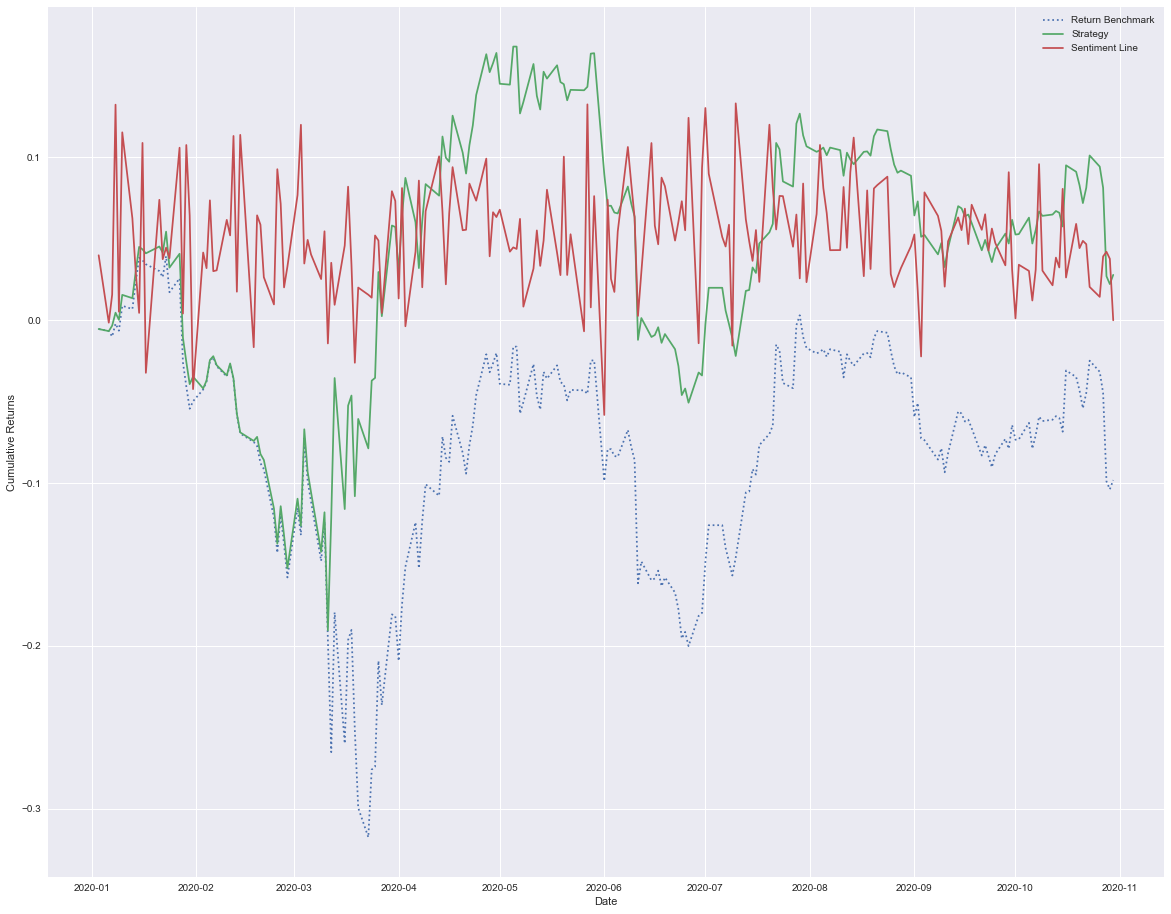

In [29]:
retl = combined_df['returns'].cumsum()
stratl = combined_df['strategy'].cumsum()
pnn = combined_df['pos'] - combined_df['neg']
plt.figure(figsize=(20,16))
plt.style.use('seaborn')
plt.plot(retl, linestyle=':', label='Return Benchmark')
plt.plot(stratl, label='Strategy')
plt.plot(pnn, linestyle='-',label='Sentiment Line')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper right')

# plt.savefig('strategy-v-benchmark.png')